C:\Users\duih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [22:14:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


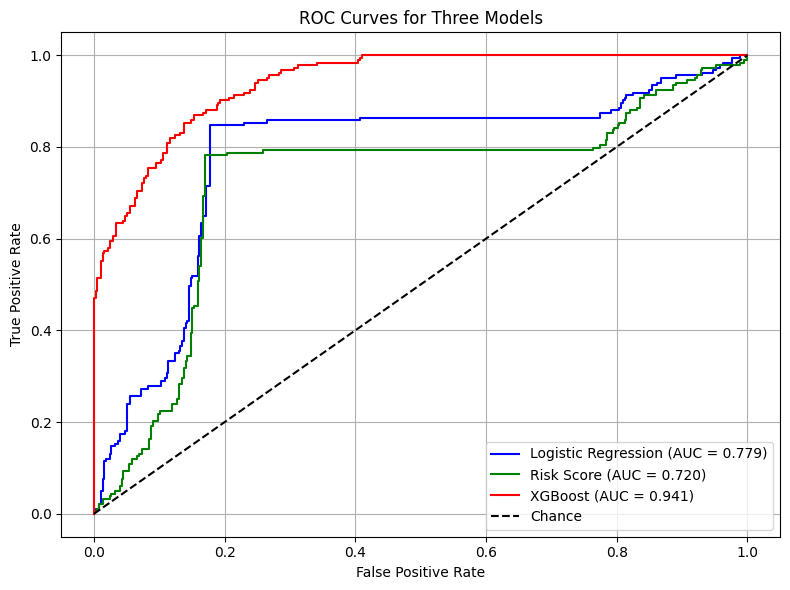

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 데이터 불러오기
df = pd.read_excel("CACS_dataset_with_binary.xlsx")

# Feature와 Target 설정
features = ['age', 'BMI', 'SBP', 'DBP', 'TC', 'LDL', 'HDL', 'TG', 'CRP', 'eGFR', 'NLR']
X = df[features]
y = df['CACS_binary']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 1. Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_prob_logreg = log_reg.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_prob_logreg)
auc_logreg = auc(fpr_logreg, tpr_logreg)

# 2. Risk Score (Logistic regression coefficients 기반 단순화 예시)
coefs = log_reg.coef_[0]
score_weights = (coefs / abs(coefs).max() * 10).round().astype(int)
risk_score = (X_test * score_weights).sum(axis=1)
fpr_risk, tpr_risk, _ = roc_curve(y_test, risk_score)
auc_risk = auc(fpr_risk, tpr_risk)

# 3. XGBoost
xgb_model = XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC = {auc_logreg:.3f})", color='blue')
plt.plot(fpr_risk, tpr_risk, label=f"Risk Score (AUC = {auc_risk:.3f})", color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})", color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Three Models")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
